# Bond Option Pricing using Hull-White Model

Value an option on a coupon paying bond using the Hull-White and Black-Karasinski model

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [1]:
from financepy.finutils.FinDate import FinDate
from financepy.market.curves.FinDiscountCurve import FinDiscountCurve
from financepy.finutils.FinFrequency import FinFrequencyTypes
from financepy.finutils.FinDayCount import FinDayCountTypes
from financepy.products.libor.FinLiborSwap import FinLiborSwap
from financepy.market.curves.FinLiborCurve import FinLiborCurve

from financepy.models.FinModelRatesHW import FinModelRatesHW
from financepy.models.FinModelRatesBK import FinModelRatesBK
from financepy.products.bonds.FinBond import FinBond
from financepy.products.bonds.FinBondOption import *

## Bond Option Valuation

In [2]:
settlementDate = FinDate(1, 12, 2019)

Set up discount curve

In [6]:
dcType = FinDayCountTypes.ACT_360
fixedFreq = FinFrequencyTypes.SEMI_ANNUAL
swap1 = FinLiborSwap(settlementDate,"1Y",0.0500,fixedFreq,dcType)
swap2 = FinLiborSwap(settlementDate,"3Y",0.0500,fixedFreq,dcType)
swap3 = FinLiborSwap(settlementDate,"5Y",0.0500,fixedFreq,dcType)
swap4 = FinLiborSwap(settlementDate,"7Y",0.0500,fixedFreq,dcType)
swap5 = FinLiborSwap(settlementDate,"10Y",0.0500,fixedFreq,dcType)
swaps = [swap1, swap2, swap3, swap4, swap5]

discountCurve = FinLiborCurve("USD_LIBOR", settlementDate, [], [], swaps)

In [5]:
discountCurve.print()

AttributeError: 'FinLiborCurve' object has no attribute 'print'

## Set up the Bond Option

First create the bond

In [73]:
maturityDate = settlementDate.addTenor("10Y")
coupon = 0.05
frequencyType = FinFrequencyTypes.SEMI_ANNUAL
accrualType = FinDayCountTypes.ACT_ACT_ICMA
bond = FinBond(maturityDate, coupon, frequencyType, accrualType)

Let's first price the bond on the libor curve

In [74]:
price = bond.valueBondUsingDiscountCurve(settlementDate, discountCurve, False)
print("Fixed Income Price:", price)

Fixed Income Price: 99.44194023445222


Then define and create the option

In [75]:
expiryDate = settlementDate.addTenor("18m")
strikePrice = 90.0
face = 100.0
optionType = FinBondOptionTypes.AMERICAN_CALL

### Hull White Model

Set the model parameters

In [76]:
sigma = 0.01
a = 0.1
hwModel = FinModelRatesHW(sigma, a)

In [77]:
strikes = [80, 85, 90, 95, 100, 105, 110, 115, 120]

In [78]:
for K in strikes:
    europeanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlementDate, discountCurve, hwModel)
    americanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlementDate, discountCurve, hwModel)
    europeanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlementDate, discountCurve, hwModel)
    americanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlementDate, discountCurve, hwModel)
    
    print("K: %9.5f EUR_CALL: %9.5f  AMER_CALL: %9.5f  EUR_PUT: %9.5f  AMER_PUT: %9.5f" %(K, v_ec, v_ac, v_ep, v_ap))

K:  80.00000 EUR_CALL:  18.08882  AMER_CALL:  19.44239  EUR_PUT:   0.00004  AMER_PUT:   0.00004
K:  85.00000 EUR_CALL:  13.45306  AMER_CALL:  14.44239  EUR_PUT:   0.00289  AMER_PUT:   0.00336
K:  90.00000 EUR_CALL:   8.87757  AMER_CALL:   9.51004  EUR_PUT:   0.06600  AMER_PUT:   0.07672
K:  95.00000 EUR_CALL:   4.73536  AMER_CALL:   5.10452  EUR_PUT:   0.56240  AMER_PUT:   0.63959
K: 100.00000 EUR_CALL:   1.82292  AMER_CALL:   1.99234  EUR_PUT:   2.28856  AMER_PUT:   2.55435
K: 105.00000 EUR_CALL:   0.46637  AMER_CALL:   0.51878  EUR_PUT:   5.57062  AMER_PUT:   6.11573
K: 110.00000 EUR_CALL:   0.07696  AMER_CALL:   0.08641  EUR_PUT:   9.81983  AMER_PUT:  10.66669
K: 115.00000 EUR_CALL:   0.00827  AMER_CALL:   0.00937  EUR_PUT:  14.38974  AMER_PUT:  15.56016
K: 120.00000 EUR_CALL:   0.00060  AMER_CALL:   0.00068  EUR_PUT:  19.02067  AMER_PUT:  20.55761


## Convergence Testing - Hull White

It is important that the tree price is stable to the number of tree steps. This can be a challenge when pricing American optionality on bonds due to the payment of coupons and the effect of accrued interest on the clean bond price.

In [79]:
from financepy.market.curves.FinFlatCurve import FinFlatCurve

In [80]:
print(settlementDate)

SUN 1 DEC 2019


In [81]:
discountCurve = FinFlatCurve(settlementDate, 0.05)

In [82]:
maturityDate = settlementDate.addTenor("10Y")
coupon = 0.05
frequencyType = FinFrequencyTypes.SEMI_ANNUAL
accrualType = FinDayCountTypes.ACT_ACT_ICMA
bond = FinBond(maturityDate, coupon, frequencyType, accrualType)
expiryDate = settlementDate.addTenor("18m")
face = 100.0

In [91]:
numStepsVector = range(50,1000,10)

In [92]:
sigma = 0.01
a = 0.1

In [93]:
K = 102.0

In [94]:
vec_ec = []
vec_ac = []
vec_ep = []
vec_ap = []

for numSteps in numStepsVector:
    
    hwModel = FinModelRatesHW(sigma, a, numSteps)
    
    europeanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlementDate, discountCurve, hwModel)

    americanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlementDate, discountCurve, hwModel)
    
    europeanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlementDate, discountCurve, hwModel)
    
    americanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlementDate, discountCurve, hwModel)
    
#    print("%d %9.5f %9.5f %9.5f %9.5f"%(numSteps, v_ec, v_ac, v_ep, v_ap))
    vec_ec.append(v_ec)
    vec_ac.append(v_ac)
    vec_ep.append(v_ep)
    vec_ap.append(v_ap)

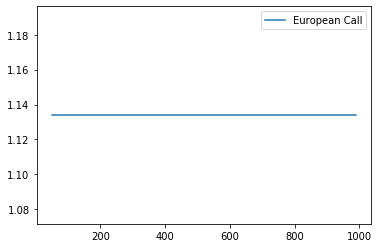

In [95]:
plt.plot(numStepsVector,vec_ec, label="European Call")
plt.legend()

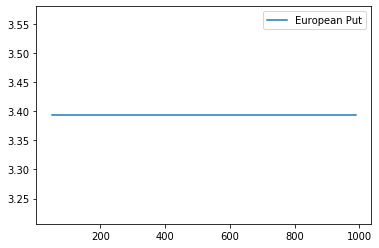

In [96]:
plt.plot(numStepsVector,vec_ep, label="European Put")
plt.legend()

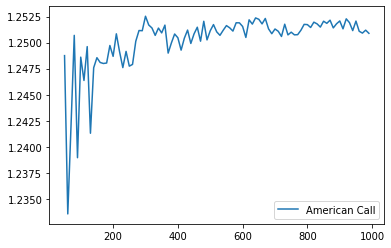

In [97]:
plt.plot(numStepsVector,vec_ac, label="American Call")
plt.legend()

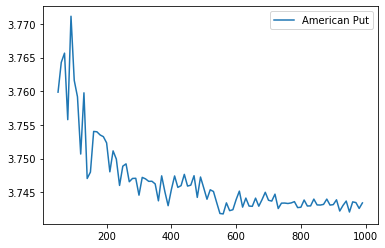

In [98]:
plt.plot(numStepsVector,vec_ap, label="American Put")
plt.legend()